<a href="https://colab.research.google.com/github/sattwiksuman/AI_for_Trash_Collection/blob/main/Trash_Collection_RL_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#<center>Efficient Trash Collection using AI</center>
---
####<center>Reinforced Learning Project - Economic Modelling of Energy and Climate Systems</center>
####<center>Data Analytics and Decision Science</center>
####<center>RWTH Aachen Business School</center>
Submitted by:<br>
Priyanka Kundagol<br>
Sattwik Suman Das<br>
Ved Nerlikar



---
#Introduction

---

To be added.

###The Environment
The Diagram below shows the environment in which the Agent would operate.
The squares in gray are the road.
The Agent is expected to collect trash from the location shown in Black boxes.
The trash is actually collected from the adjacent squares marked by a dark border on the road, i.e., squares 3, 17 and 21.

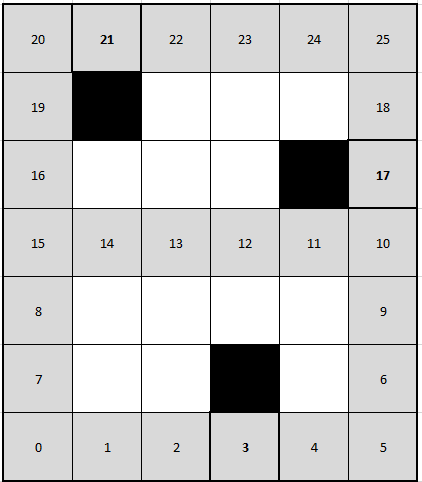

###States of the Environment:
The gray squares above depict the states in which the agent can reside. <br>
So there are 26 states in total numbered 0 to 25. <br>
The movement of the agent from one state to another is defined by defining the rewards of the adjacent states.

###Actions
At each state the agent can 5 actions as follows:
0. Do nothing
1. Move North
2. Move East
3. Move South
4. Move West 

###Action_Space: control the motion
For each state, the next state corresponding to the consequence of the 5 actions will be pre-defined as part of the environment definition. 

###Rewards
The reward of the trash locations 03, 17 and 21 are defined to reflect the amount of trash in the following manner:
1. if trash >= threshold:
        reward= percentage of trash bin full
2. else:
        reward = 0
<br>
The threshold can be set to 70% .

###Reward for road states in form of Living Penalty
A Living Penalty is defined to each of the states on the road because we want the agent to move by taking the shortest time, which would ultimately be the most efficient way to travel. <br>
Living Penalty is not defined to the start location '0' and the trash locations. <br>
The agent is expected to reside at the starting point till it needs to make it's first trip and then reside at the location from which it has collected the trash till it needs to move to the next location to collect from the next location.<br>
Living penalty can be set to -0.2

###Carrying capacity of the Agent
For the initial model, the agent is assumed to have infinite capacity. <br>
This effectively means it never has to return to the depot to empty itself.

###Timestep of the simulation
The timestep can be assumed to be one hour.<br>
In each timestep:
1. the vehicle is assumed to have one state transition.
2. the garbage is updated to new quatities




---
#Importing the packages
---

In [1]:
import gym
from gym import spaces

import numpy as np
from numpy.random import default_rng
from random import random
from random import randint

import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')

---
#Building the Environment
---

In [2]:
#Build the environment

class TrashEnv(gym.Env):

    def __init__(self):
        super(TrashEnv, self).__init__()
        # Define action and observation space
        # They must be gym.spaces objects
        n_actions = 5
        #self.action_space = spaces.Discrete(n_actions)

        self.total_states = 26 
        self.observation_space = spaces.Discrete(self.total_states)

        #Define the action space:
        self.action_space = []
        for _ in range(26):
            self.action_space.append([])
        self.action_space[0]=[0, 7, 1, 0, 0]
        self.action_space[1]=[1, 1, 2, 1, 0]
        self.action_space[2]=[2, 2, 3, 2, 1]
        self.action_space[3]=[3, 3, 4, 3, 2]
        self.action_space[4]=[4, 4, 5, 4, 3]
        self.action_space[5]=[5, 6, 5, 5, 4]
        self.action_space[6]=[6, 9, 6, 5, 6]
        self.action_space[7]=[7, 8, 7, 0, 7]
        self.action_space[8]=[8, 15, 8, 7, 8]
        self.action_space[9]=[9, 10, 9, 6, 9]
        self.action_space[10]=[10, 17, 10, 9, 11]
        self.action_space[11]=[11, 11, 10, 11, 12]
        self.action_space[12]=[12, 12, 11, 12, 13]
        self.action_space[13]=[13, 13, 11, 13, 14]
        self.action_space[14]=[14, 14, 13, 14, 15]
        self.action_space[15]=[15, 16, 14, 8, 15]
        self.action_space[16]=[16, 19, 16, 15, 16]
        self.action_space[17]=[17, 18, 17, 10, 17]
        self.action_space[18]=[18, 25, 18, 17, 18]
        self.action_space[19]=[19, 20, 19, 16, 19]
        self.action_space[20]=[20, 20, 21, 19, 20]
        self.action_space[21]=[21, 21, 22, 21, 20]
        self.action_space[22]=[22, 22, 23, 22, 21]
        self.action_space[23]=[23, 23, 24, 23, 22]
        self.action_space[24]=[24, 24, 25, 24, 23]
        self.action_space[25]=[25, 25, 25, 18, 24]
        
        #Define the Garbage locations and corresponding initial garbage quantity values = 0:
        self.garbage_quantity = {}
        self.garbage_quantity[3]=0.0
        self.garbage_quantity[17]=0.0
        self.garbage_quantity[21]=0.0    

        #Define maximum quatity of garbage that would be updated in one timestep:
        self.max_garbage_update = 0.04   
        
        # Set the living penalty
        self.living_penalty = -0.2

        #Define the Rewards:
        self.reward_space = []
        for i in range(26):
            self.reward_space.append(self.living_penalty) 
            if i in [3, 17, 21]:
                self.reward_space[i]=self.garbage_quantity[i]
        self.reward_space[0]=0.0        #reward for initial location must be zero as we allow the agent to reside at 0 before it has to start

        # Create state attribute, initialize it in reset method
        self.state = None

        #Create a variable to measure the distance covered
        self.distance_covered = 0

        #Create a variable to store the number of timesteps 
        
        
    def step(self, action):
        """State transition of the model.

        Implements the model of the environment.

        Args:
            action (int): Action the agent took.

        Returns:
            next_state (int): The next state the environment emits.
            reward (float): The reward the environment emits.
            done (bool): True if current state is terminal.
            info (dict): Infos that can be used for debugging.
        """
        #assert self.action_space.contains(action), "%r (%s) invalid" % (action, type(action))
        #assert action <= self.state, "%r is to much extraction, current state: %r" % (action, self.state)

        # Calculate the next state
        next_state = self.action_space[self.state][action]

        # Calculate the reward
        reward = self.reward_space[next_state]

        #Update the garbage_quantity and reward_space:
        if next_state not in [3, 17, 21]:
            self.garbage_quantity[3]+=random()*self.max_garbage_update
            self.reward_space[3]=self.garbage_quantity[3]
            self.garbage_quantity[17]+=random()*self.max_garbage_update
            self.reward_space[17]=self.garbage_quantity[17]
            self.garbage_quantity[21]+=random()*self.max_garbage_update
            self.reward_space[21]=self.garbage_quantity[21]
        else:
            if self.state not in [3, 7, 21]:
                if next_state == 3:
                    self.garbage_quantity[3]=0.0
                    self.reward_space[3]=self.garbage_quantity[3]
                    self.garbage_quantity[17]+=random()*self.max_garbage_update
                    self.reward_space[17]=self.garbage_quantity[17]
                    self.garbage_quantity[21]+=random()*self.max_garbage_update
                    self.reward_space[21]=self.garbage_quantity[21]
                if next_state == 17:
                    self.garbage_quantity[17]=0.0
                    self.reward_space[17]=self.garbage_quantity[17]
                    self.garbage_quantity[3]+=random()*self.max_garbage_update
                    self.reward_space[3]=self.garbage_quantity[3]
                    self.garbage_quantity[21]+=random()*self.max_garbage_update
                    self.reward_space[21]=self.garbage_quantity[21]
                if next_state == 21:
                    self.garbage_quantity[21]=0.0
                    self.reward_space[21]=self.garbage_quantity[21]
                    self.garbage_quantity[3]+=random()*self.max_garbage_update
                    self.reward_space[3]=self.garbage_quantity[3]
                    self.garbage_quantity[17]+=random()*self.max_garbage_update
                    self.reward_space[17]=self.garbage_quantity[17]
            else:
                self.garbage_quantity[3]+=random()*self.max_garbage_update
                self.reward_space[3]=self.garbage_quantity[3]
                self.garbage_quantity[17]+=random()*self.max_garbage_update
                self.reward_space[17]=self.garbage_quantity[17]
                self.garbage_quantity[21]+=random()*self.max_garbage_update
                self.reward_space[21]=self.garbage_quantity[21]

        #Update the state to the next state:
        self.state = next_state        

        #The episode will be continuous, so there will be no 'Game Over'/ 'Done'
        done = 0

        info = {}

        return self.state, reward, done, info


    def reset(self):
        """Resets the environment.

        Initializes the state.

        Returns:
            state (int): Initial state

        """
        self.state = 0
                      
        return self.state
        

    # We will not implement render and close function
    def render(self, mode='human'):
        pass
    def close (self):
        pass

---
#Testing the environment
---

In [3]:
# Create the environment
env = TrashEnv()

# Reset the environment to get initial state
state = env.reset()

# Create a list to store all states during the simulation
state_path = [state]

# Loop over each time step in the episode
# Use a policy to deforest 10 units each period unless there a less units left
# then deforest everything
done = False
for _ in range(500):
    action = randint(0,4)
    state, reward, _, _ = env.step(action)
    
    state_path.append(state)

---
#Building the Brain
---

In [4]:
#Build the Brain
'''
BRAIN PARAMETERS (TBD):

Input Layer: Should we just have the current state as the input or the current state
            along with the garbage levels / rewards of the garbage locations as the input
Output layer: output layer will have 5 nodes corresponding to the Q values
            of the 5 possible actions possible for each state
Dense layers: 2 dense layers with 10 nodes each #suggestion
Compiler:
    loss:'mse'
    optimizer: 'Adam'
    learning_rate= 0.001
    #suggestions
'''

---
#Creating a DQN Object (Agent)
---

In [5]:
#Build the DQN object = Agent
'''
PARAMETERS:

memory: list of length memory_len (we can model this as a queue)
memory_max_len: length of the memory = 50 (approximately 2 days worth of timesteps)
discount: 0.9

METHODS:

update_memory:
    get the transition made in the current timestep and append it to memory
    #transition is defined by [current_state, action, next_state, reward]
    if len of memory is == memory_max_len: pop(first element)

get_batch:
    batch_size: 10
    input_batch = randomly select min(batch_size, len(memory)) number of states
                from the memory
    target_batch = for each of the states in the input_batch, 
                corresponding element of the target_batch will be a list containing
                the Q values for all the possible actions for that state
                predicted by the Brain; here we will subsequently have to update
                the Q_value corresponding to the action played (from the memory)
                to reward + discount * max(predicted values for next_state)

'''



---
#Training
---



In [6]:
#Train the Model and save it




---
#Testing

---




In [7]:
#Test the model on a similar environment and publish the results



---
#Printing and Visualizing the Results

---






In [ ]:
#Print the results
#Report the observations
#Create a visualization
#Write a Conclusion